# Bacteria segmentation and tracking (11.5.2020)

In [1]:
import pickle
%matplotlib inline
from pylab import *
from IPython.display import clear_output
from cam import loadframe
from copy import deepcopy
from scipy.optimize import curve_fit, leastsq
from scipy.signal import fftconvolve
from numpy import fft
from scipy.ndimage import gaussian_filter
from scipy.ndimage import shift
import dill
gray()
def fig1(figsize=(8,8)):
    figure(figsize=figsize)
def fig2(figsize=(16,8)):
    figure(figsize=figsize)
def fig3(figsize=(15,8)):
    figure(figsize=figsize)

    
### library from smith 2019
import skimage.measure as skmeas
from skimage.morphology import watershed, medial_axis, skeletonize
from skimage.filters import sobel
import skimage.filters as skfilt
from skimage.measure import regionprops
import skimage.morphology as skmorph
import skimage.segmentation as skseg
import scipy.ndimage as ndi

<Figure size 432x288 with 0 Axes>

# import functions for segmentation and tracking

In [2]:
## import segmentation functions
import sys  
sys.path.insert(0, './mothermachine_funcs')

import bacteria_filters
import bacteria_measurement_funcs
import bacteria_segmentation
import bacteria_tracking_funcs
import bacteria_post_segmentation

#import correct_shift_funcs


In [3]:
reload(bacteria_filters)
reload(bacteria_measurement_funcs)
reload(bacteria_segmentation)
reload(bacteria_tracking_funcs)
reload(bacteria_post_segmentation)
#reload(correct_shift_funcs)

<module 'bacteria_post_segmentation' from './mothermachine_funcs/bacteria_post_segmentation.pyc'>

# load data already corrected for x-y shift

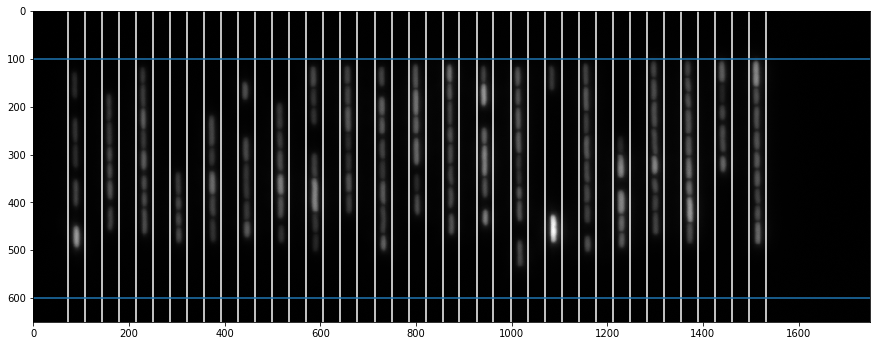

In [4]:
import pickle
with open('bacteria_shift_indx.pickle','rb') as f:
    [dr,s,N_channels,x1_ind,x2_ind,y1,y2]= pickle.load(f)
i=0    
img =shift(loadframe("../dataFL/FL%d.tiff" % i).data.astype(float), (dr[i,0],dr[i,1]), mode='wrap')

figure(figsize=(15,7))
imshow(img[s])

channel_width=mean(x2_ind-x1_ind)
for x1_temp in x1_ind:
    axvline(x1_temp,color='w')
    axvline(x1_temp+channel_width,color='w')
axhline(y1)
axhline(y2)

# run segmentation over all times and channels

In [5]:
N_channels = shape(x1_ind)[0]  # total number of channels 
#channel_selected = array([0,2,6,7,8,9,10,13,15,17,18,19,20])
channel_selected = arange(0,20)
#channel_selected=array([0])

t_skip=1
tmin=0 # minutes
dt_acq=3 # minutes
n_frames_max = 894   # limited by the experiment 
frames_selected = arange(tmin,n_frames_max,t_skip*dt_acq);
n_frames_selected = frames_selected.shape[0];
y_subtraction =60  # to remove cells outside mother machine

allbacteria_tot = [] # here will be loaded segmented images 
allbacteria2_tot = []
flags_tot=[]
checks_tot=[]
lineage_tot=[]



for ch_n, ch_selected in enumerate(channel_selected):
    print ch_selected    
    allbacteria = [] # here will be loaded segmented images 
    allbacteria2 = []
    flags=[]
    checks=[]
    cc=0
    for i in frames_selected:  # cycle on each frame
    #    clear_output(wait=True)
        print i
        try:
            segs={}
            segs2={}
            unlabelled_bacteria=[]
            bacteria=[]    
            channel_images_raw = {}

            img =shift(loadframe("../dataFL/FL%d.tiff" %(i)).data.astype(float), (dr[i,0],dr[i,1]), mode='wrap')
            img=img[s]
            channel_images_raw[0] =  img[y1:y2,x1_ind[ch_selected]:x2_ind[ch_selected]]

    #        channel_images_raw[0] =  frames_bac[i][y1:y2,x1_ind[ch_selected]:x2_ind[ch_selected]]
            # load images of each channel in a list channel_images_raw[i] where i is the channel number
    #        for ch_n, ch_selected in enumerate(channel_selected):
    #            channel_images_raw[ch_n] = frames_bac[i][y1:y2,x1_ind[ch_selected]:x2_ind[ch_selected]]

            # remove background from each well using a rollball method. 
            # it is an opening operation using a sphere - method taken from smith Scientific reports 2019
            # function in bacteria_filters.py
            channel_images= bacteria_filters.remove_background(channel_images_raw, radius=20, light_background=True)

            segs = bacteria_filters.channel_gaussian_laplace(channel_images) # scale transformation using lapalacian function in bacteria_filters.py

            flag=False
            flag2=True
            thr_strength=2.
            if cc>0:
                important_bac= len(unique(allbacteria2[cc-1][0]))-1 # all bacteria are important,
            else:
                important_bac= 20
            while not flag:
                
                segs2,thresh_array = bacteria_segmentation.bacteria_watershed(segs,maxsize=10000,minsize=100,thr_strength=thr_strength) # segmentation functions in bacteria_segmentation.py
                # multiple bacteria may appear as a single one at this point, so, if they are too long, we try to split them 
                unlabelled_bacteria = bacteria_post_segmentation.split_bacteria_in_all_wells(segs2,channel_images,min_skel_length=30) # funcs in bacteria_post_segmentation.py
                bacteria = bacteria_post_segmentation.relabel_bacteria(unlabelled_bacteria) # funcs in bacteria_post_segmentation.py                

                if cc==0:  # initialase the bacteria_lineage variable
                    temp_allbacteria2=deepcopy(bacteria)

                    temp_bacteria_lineage = {}
                    for key, bacteria_image in bacteria.items():
                        temp_bacteria_lineage.update({l.label: str(l.label)
                                for l in regionprops(bacteria_image)})
                    flag=True
                    temp_check_probs=[]

                if cc>0:
                    bacteria_lineage_old= deepcopy(bacteria_lineage)
                    
                # tracking function based on a probabilistic approach   functions in # funcs in bacteria_tracking.py
                    temp_allbacteria2, temp_bacteria_lineage,temp_check_probs = bacteria_tracking_funcs.bacteria_tracking(
                                allbacteria2[cc-1],
                                bacteria,
                                bacteria_lineage_old,
                                prob_div=0.2,   # probability of a division to occur 
                                prob_death=1e-12,  # probability of cell lysis (note that for the last bacteria in a channel this is set to higher value)
                                prob_no_change=0.8, # prob that nothing happen (i know the sum is not 1 ... still working on)
                                av_bac_length=50.,   # lenght of an average bacteria  
                                important_bac=important_bac
                                )
                    flag= bacteria_tracking_funcs.find_problems(temp_check_probs,
                                                                important_bac=important_bac)
                    if flag==False:
#                        print 'repeating cycle with stronger threshold'
                        if thr_strength>5:
                            print ' riducing important_bac to = %d'%important_bac
                            thr_strength=2.
                       
                            if important_bac<2:  # with 2 basically you are accounting only for the mother
                                print 'giving up and renaming all new bacteria'
                                #bacteria_lineage_old= deepcopy(bacteria_lineage)
                                temp_allbacteria2, temp_bacteria_lineage = bacteria_tracking_funcs.label_all_new(bacteria[0],bacteria_lineage_old)
                                flag=True
                                flag2=False
                            else:
                                important_bac-=1
                                #print important_bac
                        else: 
                            thr_strength+=1.

            allbacteria2.append(temp_allbacteria2)
            allbacteria.append(bacteria)
            bacteria_lineage=deepcopy(temp_bacteria_lineage)
            flags+=[flag2]
            checks+=[temp_check_probs]
            cc+=1 # aumenta il counter solo dopo essere uscito dal while
        except:
            break
            'There was a problem unknown'
#    allbacteria_tot.append(allbacteria) # here will be loaded segmented images 
    allbacteria2_tot.append(allbacteria2)
    allbacteria_tot.append(allbacteria)
    flags_tot.append(flags)
    checks_tot.append(checks)
    lineage_tot.append(bacteria_lineage)
with open('allbacteria2_tot_all.pickle','wb') as f:
    pickle.dump([allbacteria2_tot], f)

0
0


/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


3


/usr/local/lib/python2.7/dist-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/usr/local/lib/python2.7/dist-packages/skimage/measure/_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


6
9
12
15
18
21
24
27
30
33
36
39
42
45
48
51
54
57
60
63
66
69
72
75
78
81
84
87
90
93
96
 riducing important_bac to = 8
 riducing important_bac to = 7
 riducing important_bac to = 6
 riducing important_bac to = 5
99
102
105
108
111
114
117
120
123
126
129
132
135
138
141
144
147
150
153
156
159
 riducing important_bac to = 5
 riducing important_bac to = 4
 riducing important_bac to = 3
 riducing important_bac to = 2
162
165
168
171
 riducing important_bac to = 7
 riducing important_bac to = 6
174
177
180
183
186
189
192
195
198
201
204
207
210
213
216
219
222
225
228
231
234
237
240
243
246
249
252
255
258
261
264
267
270
273
276
279
282
285
288
291
294
297
300
303
306
309
312
315
318
321
324
327
330
333
336
339
342
345
348
351
354
357
360
363
366
369
372
375
378
381
384
387
390
393
396
399
402
405
408
411
414
417
420
423
426
429
432
435
438
441
444
447
450
453
456
459
462
465
468
471
474
477
480
483
486
 riducing important_bac to = 6
 riducing important_bac to = 5
 riducing importan

 riducing important_bac to = 5
282
285
288
291
294
297
300
303
306
309
312
315
318
321
324
327
330
333
336
339
342
345
348
351
354
357
360
363
366
369
372
375
378
381
384
387
390
 riducing important_bac to = 5
 riducing important_bac to = 4
 riducing important_bac to = 3
 riducing important_bac to = 2
393
396
399
 riducing important_bac to = 3
 riducing important_bac to = 2
402
405
408
411
414
417
420
423
426
429
432
435
438
441
444
447
450
453
456
459
462
 riducing important_bac to = 6
 riducing important_bac to = 5
465
 riducing important_bac to = 6
 riducing important_bac to = 5
 riducing important_bac to = 4
 riducing important_bac to = 3
468
471
474
477
480
483
486
489
492
495
498
501
504
507
510
513
516
519
 riducing important_bac to = 7
 riducing important_bac to = 6
 riducing important_bac to = 5
 riducing important_bac to = 4
522
 riducing important_bac to = 7
 riducing important_bac to = 6
525
 riducing important_bac to = 4
528
531
534
537
540
543
546
549
552
555
558
561
564


597
600
603
606
609
 riducing important_bac to = 5
 riducing important_bac to = 4
612
 riducing important_bac to = 4
 riducing important_bac to = 3
 riducing important_bac to = 2
615
618
621
624
627
630
633
636
639
642
645
 riducing important_bac to = 3
 riducing important_bac to = 2
648
651
654
657
660
 riducing important_bac to = 3
 riducing important_bac to = 2
663
666
669
 riducing important_bac to = 3
 riducing important_bac to = 2
672
675
678
681
684
687
690
693
 riducing important_bac to = 1
giving up and renaming all new bacteria
696
 riducing important_bac to = 3
 riducing important_bac to = 2
699
702
 riducing important_bac to = 4
 riducing important_bac to = 3
 riducing important_bac to = 2
 riducing important_bac to = 1
giving up and renaming all new bacteria
705
708
 riducing important_bac to = 2
711
 riducing important_bac to = 4
 riducing important_bac to = 3
 riducing important_bac to = 2
 riducing important_bac to = 1
giving up and renaming all new bacteria
714
717
 ri

111
114
117
120
123
126
129
132
 riducing important_bac to = 6
 riducing important_bac to = 5
 riducing important_bac to = 4
 riducing important_bac to = 3
135
138
141
144
147
150
153
156
159
162
165
168
171
174
177
180
183
186
 riducing important_bac to = 5
 riducing important_bac to = 4
189
192
195
198
201
204
207
210
213
216
219
222
225
228
231
234
237
240
243
246
249
252
 riducing important_bac to = 7
 riducing important_bac to = 6
255
258
261
264
267
270
273
276
279
282
285
288
291
294
297
300
303
306
309
312
315
318
321
324
327
330
333
336
339
 riducing important_bac to = 6
 riducing important_bac to = 5
342
345
348
351
354
357
360
363
366
369
372
375
378
381
384
387
390
393
396
399
402
405
408
411
414
417
420
423
426
429
432
435
438
441
444
447
450
453
456
459
462
465
468
471
474
477
480
483
486
489
492
495
498
501
504
507
510
513
516
519
 riducing important_bac to = 6
 riducing important_bac to = 5
 riducing important_bac to = 4
 riducing important_bac to = 3
 riducing importan

879
882
 riducing important_bac to = 3
 riducing important_bac to = 2
 riducing important_bac to = 1
giving up and renaming all new bacteria
885
888
891
 riducing important_bac to = 3
 riducing important_bac to = 2
 riducing important_bac to = 1
giving up and renaming all new bacteria
11
0
3
6
9
12
15
18
21
24
27
30
33
36
39
42
45
48
51
54
57
60
63
66
69
72
75
78
81
84
87
90
93
96
99
102
105
108
111
114
117
120
123
126
129
132
135
138
141
144
147
150
153
156
159
162
165
168
 riducing important_bac to = 3
 riducing important_bac to = 2
 riducing important_bac to = 1
giving up and renaming all new bacteria
171
174
177
180
183
186
189
192
195
198
201
204
207
210
213
216
219
222
225
228
231
234
237
240
243
246
249
252
255
258
261
264
267
270
273
 riducing important_bac to = 4
 riducing important_bac to = 3
 riducing important_bac to = 2
276
279
282
285
288
291
294
297
300
303
 riducing important_bac to = 4
 riducing important_bac to = 3
 riducing important_bac to = 2
306
309
312
315
 riduc

 riducing important_bac to = 3
 riducing important_bac to = 2
153
 riducing important_bac to = 7
 riducing important_bac to = 6
 riducing important_bac to = 5
 riducing important_bac to = 4
156
159
162
 riducing important_bac to = 7
 riducing important_bac to = 6
165
168
171
174
177
180
183
186
189
192
195
198
201
204
207
210
 riducing important_bac to = 5
213
216
219
222
225
228
231
234
237
240
243
246
249
252
255
258
261
264
267
270
273
276
279
282
285
288
291
294
297
300
303
306
309
312
315
318
321
324
327
330
333
336
 riducing important_bac to = 7
 riducing important_bac to = 6
339
342
345
348
351
354
357
360
363
366
369
372
375
378
381
384
387
390
393
396
399
402
405
408
411
414
417
420
 riducing important_bac to = 7
 riducing important_bac to = 6
 riducing important_bac to = 5
423
426
429
432
435
438
441
444
447
450
453
 riducing important_bac to = 7
 riducing important_bac to = 6
456
459
462
465
468
471
474
477
480
483
486
489
492
495
498
 riducing important_bac to = 5
 riducing

 riducing important_bac to = 4
 riducing important_bac to = 3
 riducing important_bac to = 2
 riducing important_bac to = 1
giving up and renaming all new bacteria
822
825
828
831
834
837
840
 riducing important_bac to = 4
 riducing important_bac to = 3
843
846
 riducing important_bac to = 4
849
852
 riducing important_bac to = 5
 riducing important_bac to = 4
 riducing important_bac to = 3
855
858
 riducing important_bac to = 3
861
864
867
870
873
876
879
882
885
888
891
17
0
3
 riducing important_bac to = 4
6
9
12
15
18
21
24
27
30
33
36
39
42
45
48
51
54
57
60
63
66
69
72
75
78
81
84
87
90
93
96
99
102
105
108
111
114
117
120
123
126
129
 riducing important_bac to = 6
 riducing important_bac to = 5
 riducing important_bac to = 4
 riducing important_bac to = 3
132
135
138
141
144
147
150
153
156
159
162
165
168
171
174
177
180
183
 riducing important_bac to = 7
 riducing important_bac to = 6
186
189
192
195
198
201
204
207
210
213
216
219
222
225
228
231
234
237
240
243
246
249
252
2

# plot tracking result for the first channel analysed  
note that new born bacteria have a label (intensity) that is the lowest number not taken by other bacteria, so if you analysed multiple channel, this image will new born all as yellow. To have a decent image run segmentation only on one channel. (for example only channel 0)  

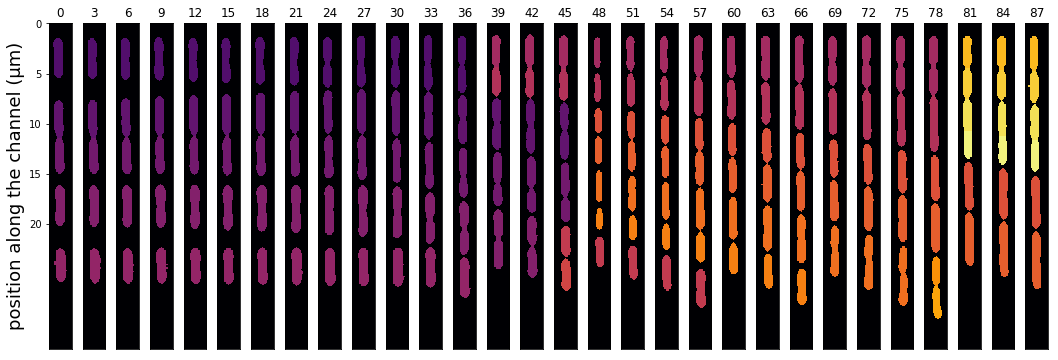

In [19]:
k=0;#n_frames_selected  
maxn=30#30/3#shape(allbacteria2)[0]
skip_n=1
n=arange(0,maxn,skip_n)
cc=1
figure(figsize=(18,6))
for nn in n:

        
    subplot(1,len(n),cc);
    cc+=1
    im=allbacteria2_tot[k][nn][0]
    imshow(where(im>0,im+5,0),cmap='inferno',vmin=0,vmax=20+5);
    title(nn*3)
    xticks([])
    yticks([])
    if nn==0:
        ax=gca()
        lx=arange(0,25,5)
        xx=lx*(100/6.5)
        ax.set_yticks(xx)
        ax.set_yticklabels(lx)
        ylabel(u'position along the channel (\u00b5m)',fontsize=18)

savefig('figure-segmentation.pdf')

# gather results

In [6]:
# make bacteria_lineage unique
cc=0
smax=0
mamma_labels=[]
for ch_n in channel_selected:
    if cc==0:
        bacteria_lineage_tot=deepcopy(lineage_tot[0])
        bacteria_lineage_tot.update({bacdic: 'ch%d__'%ch_n+str(bac_label)
                            for bacdic, bac_label in (lineage_tot[0]).items()})
    else:
        smax = smax+max(lineage_tot[cc-1], key=int)
        bacteria_lineage_tot.update({bacdic+smax: 'ch%d__'%ch_n+str(bac_label)
                            for bacdic, bac_label in (lineage_tot[cc]).items()})
    
    mamma_labels.append(smax)
    cc+=1
    

In [7]:
# here the class measurements contains all the information about single bacteria. 
# information on the i(>0 they start from 1) bacteria can be obtained for example as: 
# Area                          >> measurement.bacteria[i].bf_measurements['Area'] 
# label (discendence)           >> measurement.bacteria[i].bacteria_label

measurements = bacteria_measurement_funcs.BacteriaData()
fluorescence_backgrounds = {}
y_subtraction =0
for tpoint in arange(n_frames_selected):

    for ch_n in arange(len(channel_selected)):#(len(channel_selected)):

        bacteriaim= deepcopy(allbacteria2_tot[ch_n][tpoint][0])
        bacteriaim[bacteriaim>0]+=mamma_labels[ch_n]
        in_list=[]
        centroid_pos=[]
        # remove the not important bacteria:
        for region in regionprops(bacteriaim):
                # list the bacteria labels from the current frame
                in_list.append(region.label)
                centroid_pos.append(region.centroid[0])

        ind_sort_y = argsort(centroid_pos)  # nicola: important to sort the list
        in_list = array(in_list)
        in_list= in_list[ind_sort_y]

        for j, label in enumerate(in_list):
            if j>= important_bac-1:  # still need to think about this
                bacteriaim[bacteriaim==label]= bacteriaim.min()

        # load data into the variable        
        for region in regionprops(bacteriaim):

            measurements.add_bac_data(
                region.label, bacteria_lineage_tot, 
                region, tpoint*t_skip*3,well_label=ch_n)


measurements.compile_results(max_tpoint=n_frames_selected)

#with open('mesaurement.pickle','wb') as f:
#    pickle.dump([measurement], f)

In [8]:
with open('mesaurements_all.pickle','wb') as f:
    pickle.dump([measurements], f)

In [ ]:
channel_selected

# plot one branch 

selected bacteria
ch0__1
ch0__1_1
ch0__1_2
ch0__1_1_2
ch0__1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_2_1
ch0__1_1_1_1
ch0__1_1_1_2
ch0__1_1_1_1_1
ch0__1_1_1_1_2
ch0__1_1_1_1_1_1
ch0__1_1_1_1_1_2
ch0__1_1_1_1_1_1_1_1_1_1_1_1_2
ch0__1_1_1_1_1_1_2_1
ch0__1_1_1_1_1_1_1_1
ch0__1_1_1_1_1_1_1_2
ch0__1_1_1_1_1_1_1_2_1
ch0__1_1_1_1_1_1_1_1_1
ch0__1_1_1_1_1_1_1_1_2
ch0__1_1_1_1_1_1_1_1_1_2
ch0__1_1_1_1_1_1_1_1_1_1_1
ch0__1_1_1_1_1_1_1_1_1_1_2
ch0__1_1_1_1_1_1_1_1_1_1_1_1
ch0__1_1_1_1_1_1_1_1_1_1_1_2
ch0__1_1_1_1_1_1_1_1_1_1_1_1_1
ch0__1_1_1_1_1_1_1_1_1_1_1_1_1_1
ch0__1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1
ch0__1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_2_1_1
ch0__1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_2
ch0__1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1
ch0__1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_2
ch0__1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_2_1
ch0__1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1
ch0__1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_2
ch0__1_1_1_1_1_1_1
ch0__1_1_1_1_1_1_2
ch0__1_1_1
ch0__1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_2_1
ch0__1_1_1_1_1_1_1_

(0, 0.05)

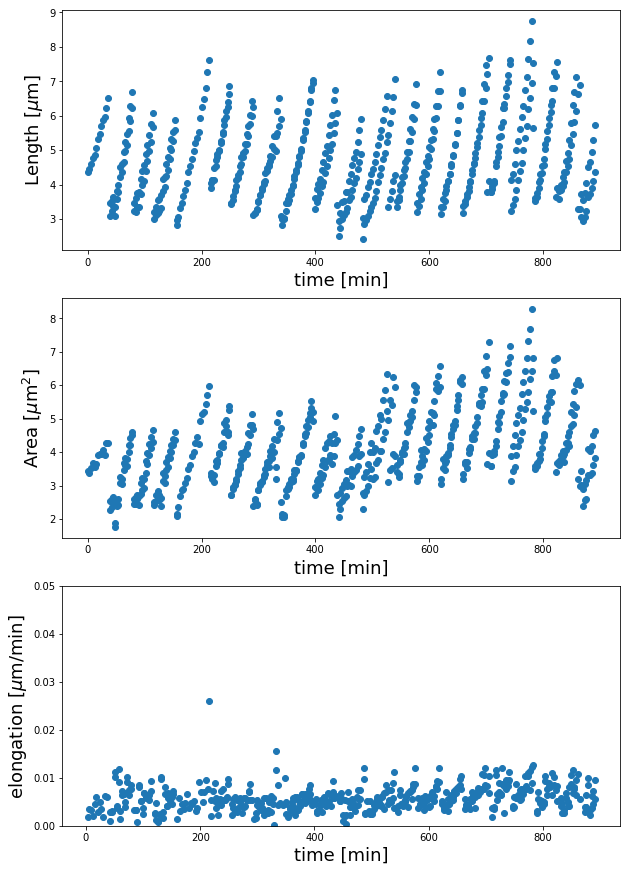

In [9]:
# genealogic tree order

pix2mic=6.5/100.
branch='ch0__1';

area=[];length=[];times=[];
print 'selected bacteria'
for numbac, (bac) in enumerate(measurements.bacteria.values()):

        #print numbac
#        if numbac == 0:
        if (bac.bacteria_label).find(branch)>=0:#str(label_mothers[k]):
            print bac.bacteria_label
            area= area+ bac.bf_measurements['Area']
            length= length + bac.bf_measurements['Length']
            times = times+ bac.timepoints
area=array(area)*(pix2mic**2)
length =array(length)*pix2mic
times=array(times) # images every 3minutes
growth_rate = diff(length)*(pix2mic)/3; growth_rate[growth_rate<0] = nan
print n_frames_selected
figure(figsize=(10,15))
subplot(311);plot(times,length,'o'); xlabel('time [min]',fontsize=18); ylabel('Length [$\mu$m]',fontsize=18)
subplot(312);plot(times,area,'o');xlabel('time [min]',fontsize=18); ylabel('Area [$\mu$m$^{2}$]',fontsize=18);
subplot(313);plot(times[1:],growth_rate,'o');xlabel('time [min]',fontsize=18); ylabel('elongation [$\mu$m/min]',fontsize=18);
ylim(0,0.05)

selected bacteria
ch0__1
ch0__1_1
ch0__1_1_1_1
ch0__1_1_1_1_1
ch0__1_1_1_1_1_1
ch0__1_1_1_1_1_1_1_1
ch0__1_1_1_1_1_1_1_1_1
ch0__1_1_1_1_1_1_1_1_1_1_1
ch0__1_1_1_1_1_1_1_1_1_1_1_1
ch0__1_1_1_1_1_1_1_1_1_1_1_1_1
ch0__1_1_1_1_1_1_1_1_1_1_1_1_1_1
ch0__1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1
ch0__1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1
ch0__1_1_1_1_1_1_1
ch0__1_1_1
ch0__1_1_1_1_1_1_1_1_1_1
ch0__1_1_1_1_1_1_1_1_1_1_1_1_1_1_1
ch0__1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1
ch0__1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1
298


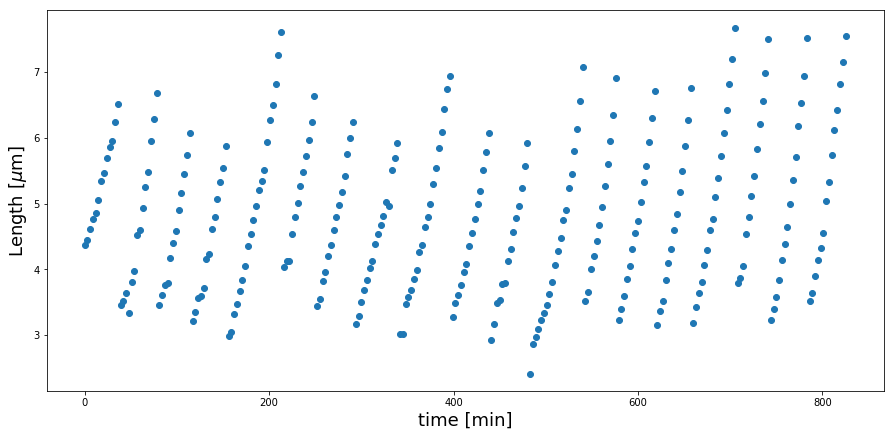

In [21]:
# look for my history order

pix2mic=6.5/100.
branch='ch0__1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1';

area=[];length=[];times=[];
print 'selected bacteria'
for numbac, (bac) in enumerate(measurements.bacteria.values()):

        #print numbac
#        if numbac == 0:
        if (branch).find(bac.bacteria_label)>=0:#str(label_mothers[k]):
            print bac.bacteria_label
            area= area+ bac.bf_measurements['Area']
            length= length + bac.bf_measurements['Length']
            times = times+ bac.timepoints
area=array(area)*(pix2mic**2)
length =array(length)*pix2mic
times=array(times) # images every 3minutes
growth_rate = diff(length); growth_rate[growth_rate<0] = nan
print n_frames_selected
figure(figsize=(15,7))
#subplot(311);
plot(times,length,'o'); xlabel('time [min]',fontsize=18); ylabel('Length [$\mu$m]',fontsize=18)
#subplot(312);plot(times,area,'o');xlabel('time [min]',fontsize=18); ylabel('Area [$\mu$m$^{2}$]',fontsize=18);
#subplot(313);plot(times[1:],growth_rate,'o');xlabel('time [min]',fontsize=18); ylabel('elongation [1/min]',fontsize=18);
savefig('story of a mother.pdf')

#  size (at birth) vs mother growth rate

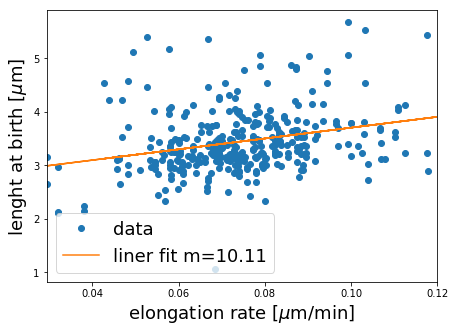

In [49]:
pix2mic=6.5/100.
min_tracking_time=6
gr_mother_tot=[];size_bd=[];
#print 'selected bacteria'
for numbac, (bac) in enumerate(measurements.bacteria.values()):
        if bac.bacteria_label.find('_')>=0:# we exclude the ones which no have a mother in the mothermachine
            area= bac.bf_measurements['Area']
            length= bac.bf_measurements['Length']
            gr= mean(diff(length))*(pix2mic)/3.
            mother_name = bac.bacteria_label[:-2]
            son_name =bac.bacteria_label[:-2]+'_1'
            #print mother_name
            if (len(length)>min_tracking_time) & (gr>0.02):
                for numbac_mother, (bac_mother) in enumerate(measurements.bacteria.values()):
                    if bac_mother.bacteria_label == mother_name:
                        for numbac_son, (bac_son) in enumerate(measurements.bacteria.values()):
                            if bac_son.bacteria_label == son_name:
                                area_mother= bac_mother.bf_measurements['Area']
                                length_mother= bac_mother.bf_measurements['Length']
                                gr_mother=mean(diff(length_mother))*(pix2mic)/3.
                                if (len(length_mother)>min_tracking_time)*(gr_mother>0.02)*(length[0]<(6./(pix2mic))) :
                                        gr_mother_tot.append(gr_mother)
                                        size_bd.append(length[0]*(pix2mic))
gr= deepcopy(array(gr_mother_tot))
size_bd = array(size_bd)

figure(figsize=(7,5))
plot(gr,size_bd,'o'); xlabel('elongation rate [$\mu$m/min]',fontsize=18); ylabel('lenght at birth [$\mu$m]',fontsize=18)
xlim(gr.min(),0.12)

# fit with straigth line
ind_fit = (gr<0.12) & (gr>0.02)
p=polyfit(gr[ind_fit],size_bd[ind_fit],1)
#poly = poly1d(p)
plot(gr,polyval(p,gr),'-')
legend(('data','liner fit m=%0.2f'%p[0]),fontsize=18)
savefig('growth law.pdf')

In [43]:
(7./(pix2mic))

107.6923076923077

# length increase as a function of the growth rate

selected bacteria


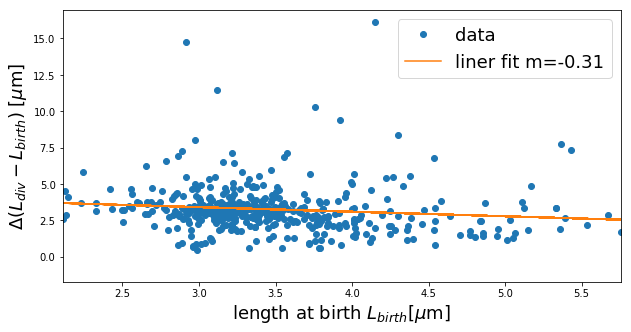

In [52]:
pix2mic=6.5/100.
min_tracking_time=5
div_time=[];length_bd=[];length_div=[]
print 'selected bacteria'
for numbac, (bac) in enumerate(measurements.bacteria.values()):
        if bac.bacteria_label.find('_')>=0:# we exclude the ones which no have a mother in the mothermachine
            length= bac.bf_measurements['Length']
            gr= mean(diff(length))*(pix2mic)/3
            if (len(length)>min_tracking_time) & (gr>0.02):
                for numbac_mother, (bac_mother) in enumerate(measurements.bacteria.values()):
                    if bac_mother.bacteria_label == mother_name:
                        for numbac_son, (bac_son) in enumerate(measurements.bacteria.values()):
                            if bac_son.bacteria_label == son_name:
                                div_time.append(len(length))
                                length_bd.append(length[0])
                                length_div.append(length[-1])

div_time = array(div_time)*(3) ## 3 minutes each image
length_bd = array(length_bd)*(pix2mic)
length_div = array(length_div)*(pix2mic)


figure(figsize=(10,5))
plot(length_bd,length_div - length_bd,'o'); xlabel('length at birth $L_{birth}$[$\mu$m]',fontsize=18); ylabel('$\Delta$($L_{div} - L_{birth}$) [$\mu$m]',fontsize=18)
#xlim(gr.min(),60)
ind_plot = (length_bd<6) & (length_bd>2)
p=polyfit(length_bd[ind_plot],length_div[ind_plot] - length_bd[ind_plot],1)
#poly = poly1d(p)
plot(length_bd,polyval(p,length_bd),'-')
legend(('data','liner fit m=%0.2f'%p[0]),fontsize=18)
xlim(length_bd[ind_plot].min(),length_bd[ind_plot].max())
savefig('constant added mass and size convergence.pdf')



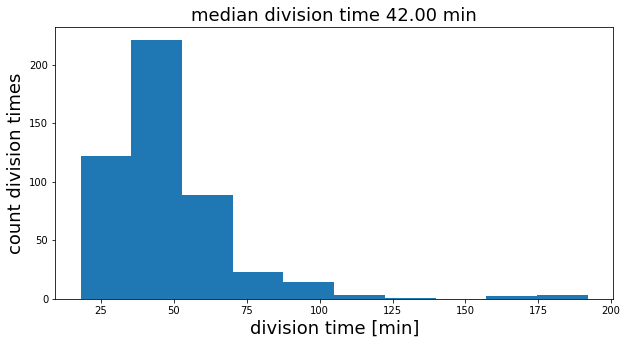

In [51]:
figure(figsize=(10,5))
hist(div_time); xlabel('division time [min]',fontsize=18); 
ylabel('count division times',fontsize=18); 
title('median division time %0.2f min'%median(div_time),fontsize=18)
savefig('division times and lenght increase as a function of growth rate.pdf')

In [ ]:
div_time